

#### Model Parameters
- Beta
- Gamma
- Mu


#### Network Parameters
- Node Number
- Edge Number
- Rewiring Probability (Watts-Strogatz)
- Edge Probability (Erdose-Reyni)


#### Network statistics
- Centrality
- Degree Distribution
- Clustering
- Shortest Path
- Diameter
- Density
- Assortativity


In [137]:
import numpy as np # Numerical Operations
import networkx as nx # Network Analysis
import ndlib.models.ModelConfig as mc # Network Model Configuration
import ndlib.models.epidemics as ep # Epidemic Networks
import dataclasses # Dataclasses
import matplotlib.pyplot as plt # Plotting
from matplotlib import cm # Colormaps
import pandas as pd # Dataframes
from matplotlib.animation import FuncAnimation
from PIL import Image
from functools import partial

In [9]:
def networkFromCSV(filePath):
    dataSet = pd.read_csv(filePath, index_col=0, delimiter=';') 

    dataSet.columns = dataSet.index

    network = nx.from_pandas_adjacency(dataSet)

    return network

In [34]:
def unconnectedNetworkStats(network):
    stats = {}

    stats['nodes'] = network.number_of_nodes()
    stats['edges'] = network.number_of_edges()
    stats['density'] = nx.density(network)
    stats['clusteringCoefficient'] = nx.average_clustering(network)
    stats['averageDegree'] = np.mean([d for n, d in network.degree()])

    nodeCentrality = nx.degree_centrality(network)
    stats['largestCentralityNode'] = max(nodeCentrality, key=nodeCentrality.get)
    stats['largestCentralityValue'] = nodeCentrality[stats['largestCentralityNode']]
    stats['largestCentralityIndex'] = list(nodeCentrality.keys()).index(stats['largestCentralityNode'])

    return stats

In [128]:
def plotNetwork(network, title, layout, colors, withLabels = True):
    plt.figure(figsize=(12, 8))

    plt.clf()

    nx.draw(network, 
            pos = layout, 
            node_size = 30, 
            node_color = colors, 
            edge_color = 'grey', 
            width = 0.25,
            font_size = 6,
            with_labels = withLabels) 

    plt.title(title, fontsize=15)

    plt.show()

In [149]:
def plotSingleNetworkInfection(t, modelIterations, network, layout, colors, colorDictionary, title):
    plt.clf()

    plt.title(title + ' at time ' + str(t), fontsize=15)
    
    for node in modelIterations[t]['status']:
        if modelIterations[t]['status'][node] == 0:
            colorDictionary[node] = 'blue'
        elif modelIterations[t]['status'][node] == 1:
            colorDictionary[node] = 'red'
        else:
            colorDictionary[node] = 'green'

    colors = [colorDictionary[node] for node in network.nodes()]

    nx.draw(network, 
            pos = layout, 
            node_size = 30, 
            node_color = colors, 
            edge_color = 'grey', 
            width = 0.25,
            font_size = 6,
            with_labels = False) 

In [35]:
sociopatternsNetwork = networkFromCSV('transmission_network.csv')

sociopatternsNetStats = unconnectedNetworkStats(sociopatternsNetwork)


In [38]:
print('Nodes:', sociopatternsNetStats['nodes'])
print('Edges:', sociopatternsNetStats['edges'])
print('Density:', sociopatternsNetStats['density'])
print('Clustering Coefficient:', sociopatternsNetStats['clusteringCoefficient'])
print('Average Degree:', sociopatternsNetStats['averageDegree'])
print('Largest Centrality Node:', sociopatternsNetStats['largestCentralityNode'])
print('Largest Centrality Value:', sociopatternsNetStats['largestCentralityValue'])
print('Largest Centrality Index:', sociopatternsNetStats['largestCentralityIndex'])

Nodes: 374
Edges: 1265
Density: 0.018135940703359093
Clustering Coefficient: 0.2959852276749502
Average Degree: 6.764705882352941
Largest Centrality Node: 1599
Largest Centrality Value: 0.1260053619302949
Largest Centrality Index: 20


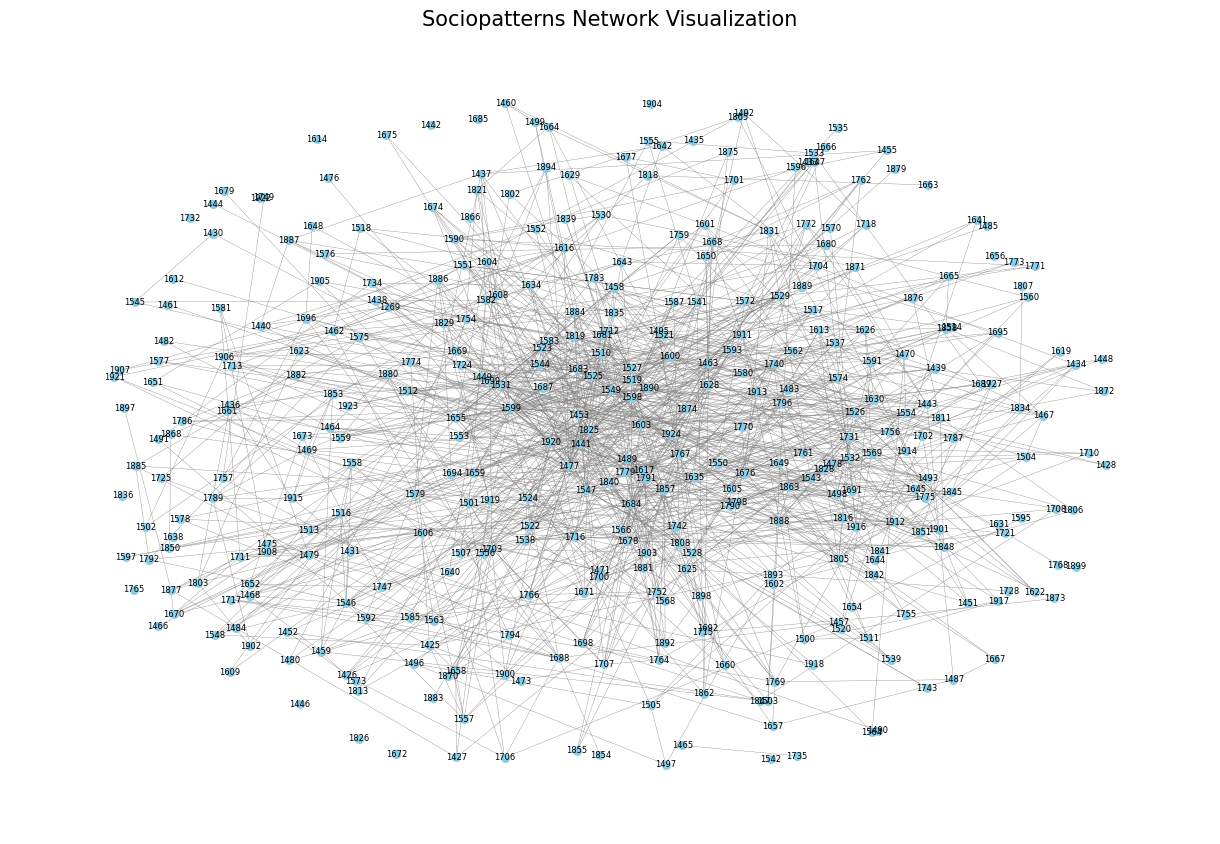

In [87]:
springLayout = nx.spring_layout(sociopatternsNetwork, k=1.5)

plotNetwork(sociopatternsNetwork, 'Sociopatterns Network Visualization', springLayout)

In [150]:
X0 = 0.9
Y0 = 0.1
Z0 = 0.0
N = X0 + Y0 + Z0
beta = 0.4
gamma = 0.1
mu = 0.02

In [151]:
timeMax = 250
timeMin = 0
timeInterval = 1
timeSpan = np.arange(timeMin, timeMax, timeInterval)

In [152]:
infectedNodes = sociopatternsNetStats['largestCentralityIndex']

In [180]:
sociopatternsModelSIR = ep.SIRModel(sociopatternsNetwork)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

In [181]:
modelConfig.add_model_parameter("fraction_infected", 0.0)

for n in sociopatternsNetwork.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)


modelConfig.add_node_configuration("Infected", infectedNodes, 1)

sociopatternsModelSIR.set_initial_status(modelConfig)

C:\Users\Victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ndlib\models\DiffusionModel.py:169: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  warnings.warn(


In [182]:
ITERATION_NUM = 0

In [183]:
sociopatternsModelSIR.set_initial_status(modelConfig)

modelIterations = sociopatternsModelSIR.iteration_bunch(timeMax)

sociopatternsModelSIRResults = sociopatternsModelSIR.build_trends(modelIterations)

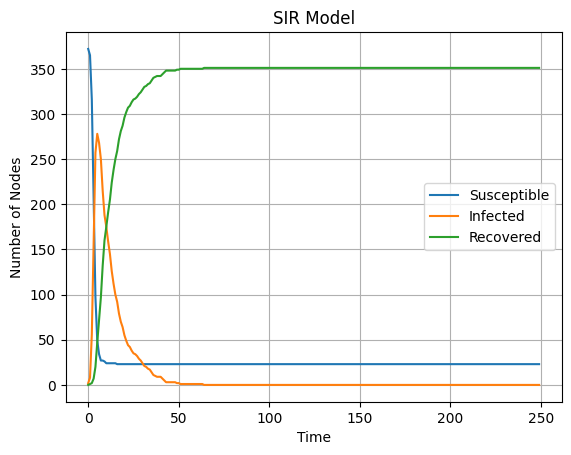

In [184]:
plt.figure()
for r in sociopatternsModelSIRResults:
    plt.plot(timeSpan, 
             r['trends']['node_count'][0],
             label='Susceptible')
    plt.plot(timeSpan, 
             r['trends']['node_count'][1],
             label='Infected')
    plt.plot(timeSpan, 
             r['trends']['node_count'][2],
             label='Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

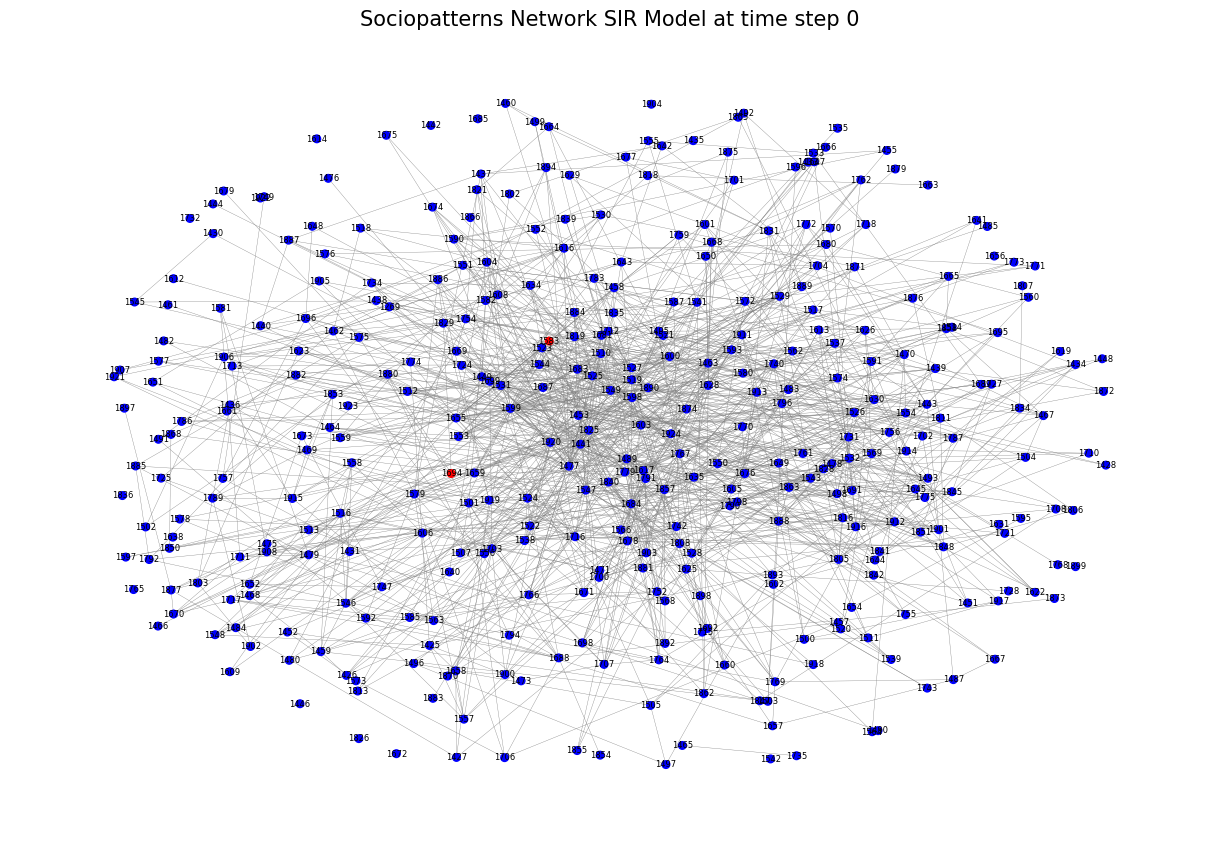

In [185]:
colorDictionary = {}
colors = []

for node in modelIterations[0]['status']:
    if modelIterations[0]['status'][node] == 0:
        colorDictionary[node] = 'blue'
    elif modelIterations[0]['status'][node] == 1:
        colorDictionary[node] = 'red'
    else:
        colorDictionary[node] = 'green'

colors = [colorDictionary[node] for node in sociopatternsNetwork.nodes()]

plotNetwork(sociopatternsNetwork, 'Sociopatterns Network SIR Model at time step 0', springLayout, colors, True)


In [186]:
colorDictionary = {}
colors = []
title = 'Sociopatterns Network SIR Model'
saveName = 'sociopatternsSIRModel.gif'

fig = plt.figure(figsize=(12, 8))

partialFunction = partial(plotSingleNetworkInfection, 
                          modelIterations=modelIterations, 
                          network=sociopatternsNetwork, 
                          layout=springLayout, 
                          colors=colors, 
                          colorDictionary=colorDictionary,
                          title=title)

gif = FuncAnimation(fig, partialFunction, frames=timeSpan, repeat=False)

gif.save(saveName, writer='pillow', fps=1)
plt.close(fig)

### Network Experimenting

In [117]:
nodeNum = 100
edgeNum = 3

smallWattz = nx.watts_strogatz_graph(10, 2, 0.1)

barabasiNet = nx.barabasi_albert_graph(nodeNum, edgeNum)
wattsStrogatz = nx.watts_strogatz_graph(nodeNum, edgeNum, 0.1)
erdosReyni = nx.erdos_renyi_graph(nodeNum, 0.01)
binomial = nx.binomial_graph(nodeNum, 0.1)



In [118]:
barabasiDia = nx.diameter(barabasiNet)
barabasiCluster = nx.cluster.average_clustering(barabasiNet)
barabasiShortestPath = nx.average_shortest_path_length(barabasiNet)
barabasiDensity = nx.density(barabasiNet)
barabasiAssort = nx.degree_assortativity_coefficient(barabasiNet)
barabasiComponents = nx.number_connected_components(barabasiNet)

print("Barabasi-Albert Graph")
print("Diameter: ", barabasiDia)
print("Cluster Coefficient: ", barabasiCluster)
print("Average Shortest Path: ", barabasiShortestPath)
print("Density: ", barabasiDensity)
print("Assortativity: ", barabasiAssort)
print("Connected Components: ", barabasiComponents)

Barabasi-Albert Graph
Diameter:  5
Cluster Coefficient:  0.10104161198278845
Average Shortest Path:  2.6680808080808083
Density:  0.058787878787878785
Assortativity:  -0.12696844343772698
Connected Components:  1


In [200]:
X0 = 0.9
Y0 = 0.1
Z0 = 0.0
N = X0 + Y0 + Z0
beta = 0.4
gamma = 0.1
mu = 0.02

In [201]:
time = 1000
timeInterval = 1
timeSpan = np.arange(0, time, timeInterval)

{'iteration': 1, 'status': {1543: 1, 1626: 1, 1593: 1, 1466: 1, 1528: 1, 1566: 1, 1884: 1}, 'node_count': {0: 366, 1: 8, 2: 0}, 'status_delta': {0: -7, 1: 7, 2: 0}}


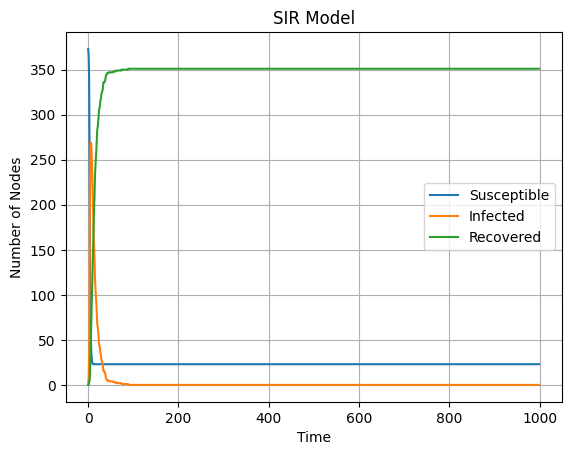

In [254]:
modelSIR = ep.SIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)


iterationNum = 1
test = modelIterations[iterationNum]

print(test)

result = modelSIR.build_trends(modelIterations)


plt.figure()
for r in result:
    plt.plot(timeSpan, 
             r['trends']['node_count'][0],
             label='Susceptible')
    plt.plot(timeSpan, 
             r['trends']['node_count'][1],
             label='Infected')
    plt.plot(timeSpan, 
             r['trends']['node_count'][2],
             label='Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

{'iteration': 1, 'status': {1628: 1, 1593: 1, 1907: 1}, 'node_count': {0: 370, 1: 4, 2: 0}, 'status_delta': {0: -3, 1: 3, 2: 0}}


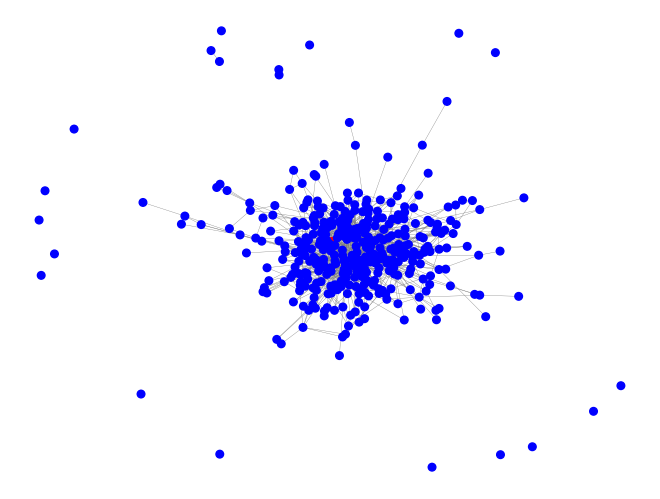

In [280]:
modelSIR = ep.SIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)


iterationNum = 1
test = modelIterations[iterationNum]

print(test)

result = modelSIR.build_trends(modelIterations)


colorDictionary = {}
colors = []


for node in modelIterations[0]['status']:
    if modelIterations[0]['status'][node] == 0:
        colorDictionary[node] = 'blue'
    elif modelIterations[0]['status'][node] == 1:
        colorDictionary[node] = 'red'
    else:
        colorDictionary[node] = 'green'

colors = [colorDictionary[node] for node in network.nodes()]


layout = nx.spring_layout(network, k=0.3)

nx.draw(network,
        layout,
        node_size=30, 
        node_color = colors, 
        edge_color = 'grey', 
        width = 0.25) 



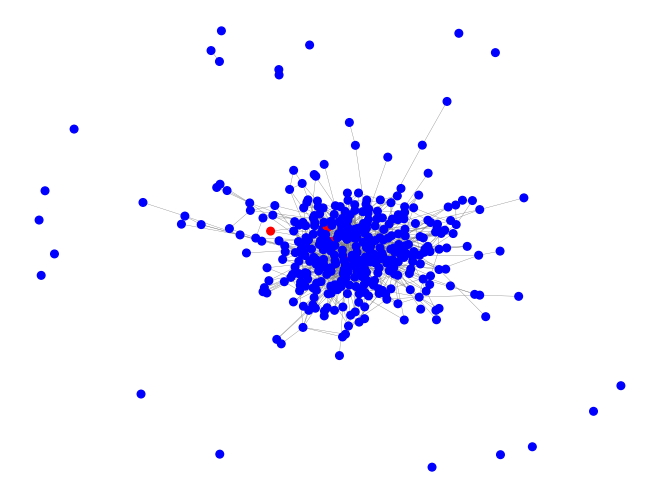

In [294]:
t = 1

for node in modelIterations[t]['status']:
    if modelIterations[t]['status'][node] == 0:
        colorDictionary[node] = 'blue'
    elif modelIterations[t]['status'][node] == 1:
        colorDictionary[node] = 'red'
    else:
        colorDictionary[node] = 'green'

colors = [colorDictionary[node] for node in network.nodes()]

nx.draw(network,
        layout,
        node_size=30, 
        node_color = colors, 
        edge_color = 'grey', 
        width = 0.25) 

[{'trends': {'node_count': {0: [373, 371, 370, 370, 369, 369, 369, 369, 369, 369, 368, 367, 367, 367, 367, 365, 363, 363, 363, 362, 361, 360, 360, 360, 356, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 354, 354, 354, 354, 350, 346, 343, 343, 343, 342, 340, 340, 336, 323, 316, 309, 305, 304, 303, 303, 298, 296, 295, 293, 292, 286, 282, 280, 275, 269, 265, 261, 253, 240, 237, 234, 232, 232, 230, 223, 217, 205, 201, 196, 195, 193, 191, 185, 185, 185, 184, 184, 184, 180, 176, 172, 166, 164, 164, 161, 158, 152, 145, 145, 144, 144, 136, 135, 134, 131, 129, 125, 122, 118, 113, 107, 106, 103, 100, 99, 97, 94, 93, 92, 89, 88, 85, 83, 82, 82, 82, 82, 82, 81, 80, 78, 77, 77, 76, 76, 76, 75, 75, 75, 74, 73, 73, 73, 73, 72, 71, 71, 67, 66, 65, 65, 65, 65, 63, 63, 61, 61, 56, 56, 54, 54, 54, 54, 53, 53, 53, 52, 52, 52, 52, 52, 51, 49, 49, 49, 49, 49, 49, 48, 48, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 44, 44, 43, 43, 42, 42, 42, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40,

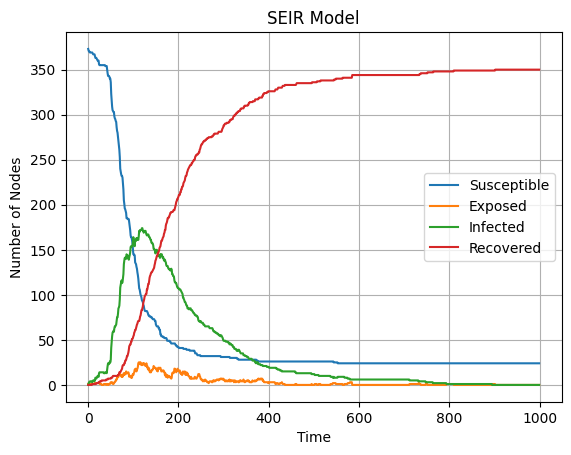

In [274]:
modelSIR = ep.SEIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('alpha', 0.01)
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)

result = modelSIR.build_trends(modelIterations)

print(result)
print(result[0]['trends']['node_count'][2])

plt.figure()
for r in result:
    plt.plot(timeSpan, 
             r['trends']['node_count'][0],
             label='Susceptible')
    plt.plot(timeSpan, 
             r['trends']['node_count'][1],
             label='Exposed')
    plt.plot(timeSpan, 
             r['trends']['node_count'][2],
             label='Infected')
    plt.plot(timeSpan, 
             r['trends']['node_count'][3],
             label='Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SEIR Model')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
def plot_graph_spring(network):
    ax = plt.figure(figsize=(10, 10)).add_subplot()
    layout = nx.spring_layout(network)
    node_sizes = np.zeros_like(network)
    for edge in network.edges:
        node_sizes[edge[0]] += 1
        node_sizes[edge[1]] += 1
    nx.draw(network, width=0.5, pos=layout, node_size=10, ax=ax)

def plot_graph_spectral(network):
    ax = plt.figure(figsize=(10, 10)).add_subplot()
    layout = nx.spring_layout(network)
    node_sizes = np.zeros_like(network)
    for edge in network.edges:
        node_sizes[edge[0]] += 1
        node_sizes[edge[1]] += 1
    nx.draw(network, width=0.5, pos=layout, node_size=10, ax=ax)

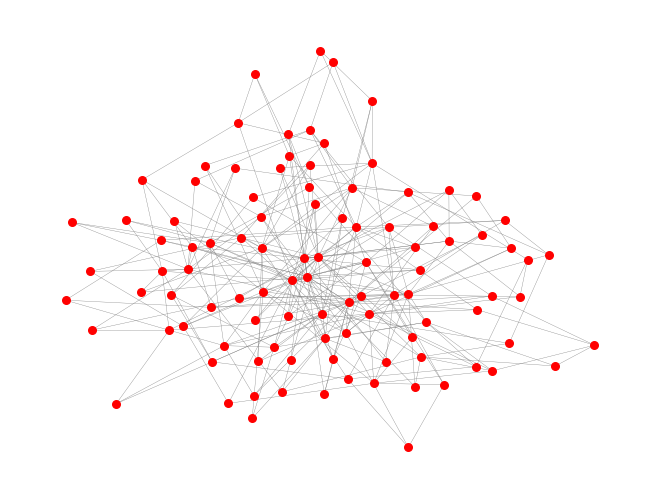

In [127]:
layout = nx.spring_layout(barabasiNet, k=0.3)

nx.draw(barabasiNet, 
        layout, 
        node_size=30, 
        node_color = 'red', 
        edge_color = 'grey', 
        width = 0.25) 

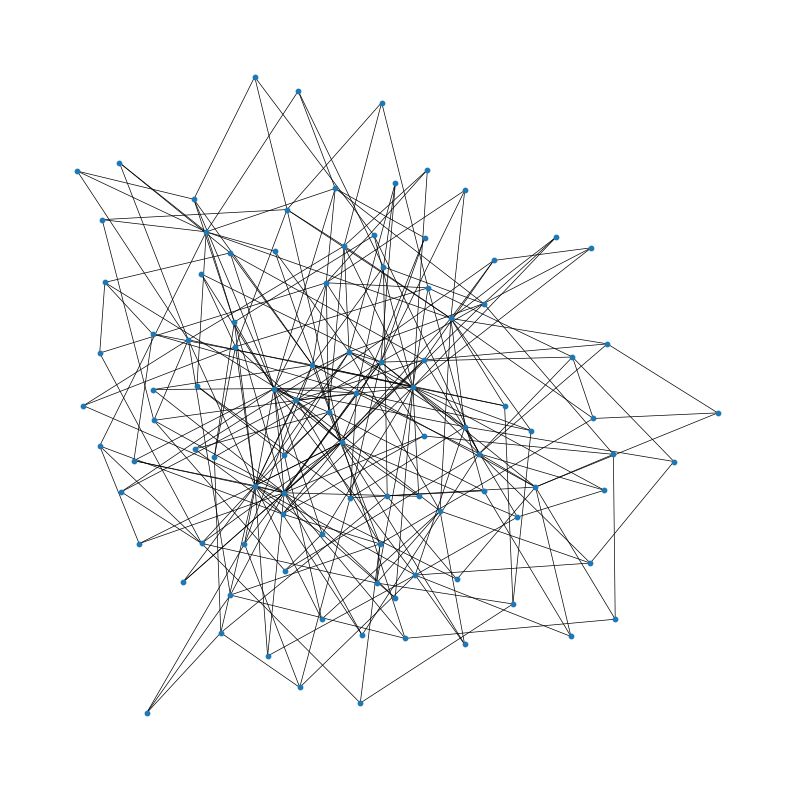

In [136]:
plot_graph_spring(barabasiNet)

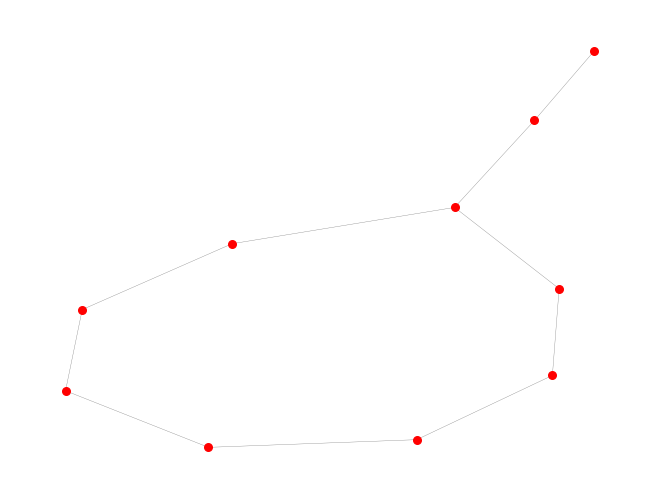

In [128]:
nx.draw(smallWattz, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25)

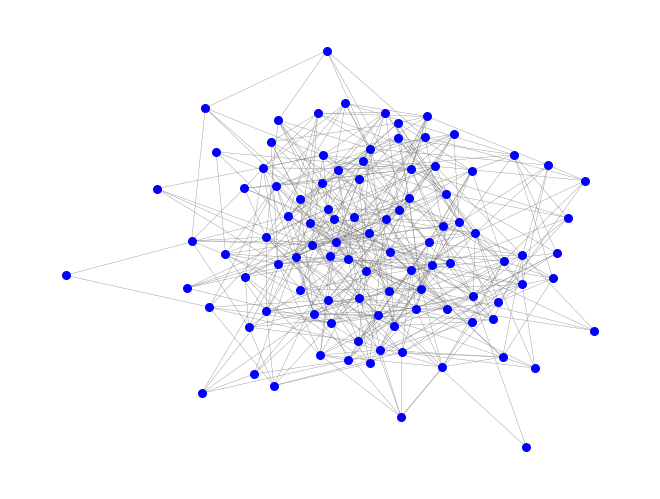

In [129]:
nx.draw(binomial, node_size=30, node_color = 'blue', edge_color = 'grey', width = 0.25)

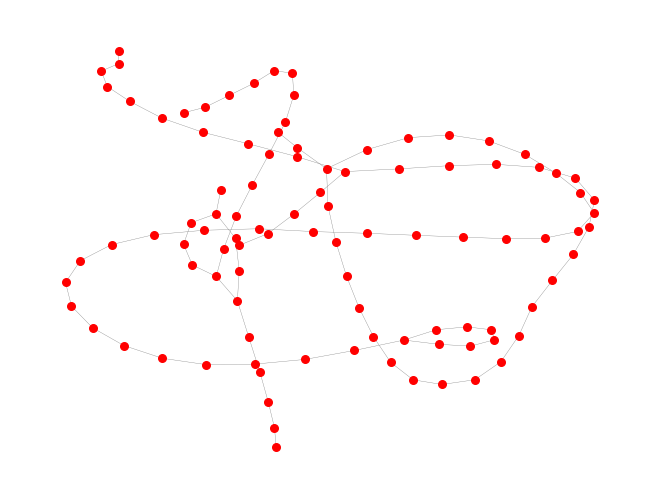

In [130]:
layout = nx.spring_layout(wattsStrogatz, k=0.3)


nx.draw(wattsStrogatz, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25) 

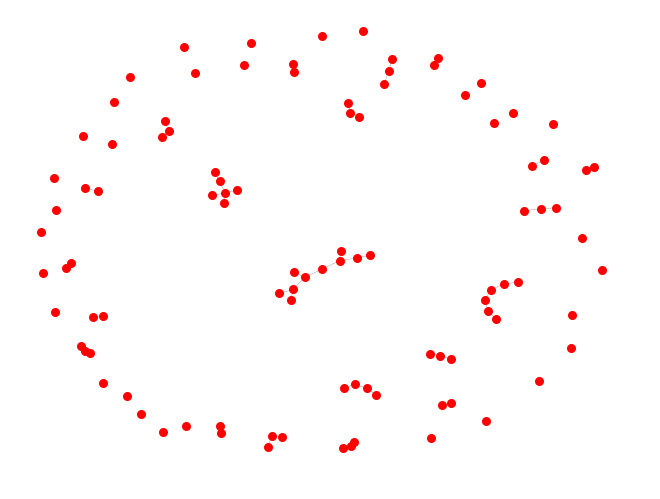

In [131]:
layout = nx.kamada_kawai_layout(erdosReyni)

nx.draw(erdosReyni, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25) 